In [29]:
#RUN ONLY WHEN YOU ARE RUNNING IT FROM GOOGLE COLLAB 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [30]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2

In [31]:
img_width,img_height=224,224

model=MobileNetV2(weights='imagenet',
                include_top=False,
                input_shape=(img_height,img_width,3)
                )

In [32]:
for layer in model.layers:
    layer.trainable=False

In [34]:
def add_layer_at_bottom(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

## Data Prep

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
import os
#Change the directory location as per your path
train_data_dir = '/content/drive/MyDrive/Segmented Medicinal Leaf Images'
val_data_dir = '/content/drive/MyDrive/Test folders'

train_data = []


for folder_name in os.listdir(train_data_dir):
    folder_path = os.path.join(train_data_dir, folder_name)

    if os.path.isdir(folder_path):

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            train_data.append((file_path, folder_name))


print(train_data[:5])


first_image_path, first_leaf_name = train_data[0]
print("First Image Path:", first_image_path)
print("Leaf Name:", first_leaf_name)


[('/content/drive/MyDrive/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-010.jpg', 'Psidium Guajava (Guava)'), ('/content/drive/MyDrive/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-013.jpg', 'Psidium Guajava (Guava)'), ('/content/drive/MyDrive/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-011.jpg', 'Psidium Guajava (Guava)'), ('/content/drive/MyDrive/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-007.jpg', 'Psidium Guajava (Guava)'), ('/content/drive/MyDrive/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-008.jpg', 'Psidium Guajava (Guava)')]
First Image Path: /content/drive/MyDrive/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-010.jpg
Leaf Name: Psidium Guajava (Guava)


In [47]:
# from tensorflow.keras.layers.preprocessing.image_preprocessing import HORIZONTAL

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=45,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

val_datagen=ImageDataGenerator(rescale=1./255)

In [48]:
batch_size=32

In [49]:
import os


print("Files in validation data directory:")
for root, dirs, files in os.walk(val_data_dir):
    for file in files:
        print(os.path.join(root, file))


Files in validation data directory:
/content/drive/MyDrive/Test folders/Alpinia Galanga (Rasna)/AG-S-004.jpg
/content/drive/MyDrive/Test folders/Alpinia Galanga (Rasna)/AG-S-005.jpg
/content/drive/MyDrive/Test folders/Alpinia Galanga (Rasna)/AG-S-003.jpg
/content/drive/MyDrive/Test folders/Alpinia Galanga (Rasna)/AG-S-002.jpg
/content/drive/MyDrive/Test folders/Alpinia Galanga (Rasna)/AG-S-001.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-122.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-123.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-121.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-120.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-119.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-004.jpg
/content/drive/MyDrive/Test folders/Amaranthus Viridis (Arive-Dantu)/AV-S-001.jpg
/content/drive/MyDrive/Te

In [50]:
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')


Found 1685 images belonging to 30 classes.
Found 288 images belonging to 30 classes.


In [52]:
train_class_names = set()
num_train_samples=0
for i in train_generator.filenames:
    train_class_names.add(i.split('/')[0])
    num_train_samples+=1
print(num_train_samples)
train_class_names

1685


{'Alpinia Galanga (Rasna)',
 'Amaranthus Viridis (Arive-Dantu)',
 'Artocarpus Heterophyllus (Jackfruit)',
 'Azadirachta Indica (Neem)',
 'Basella Alba (Basale)',
 'Brassica Juncea (Indian Mustard)',
 'Carissa Carandas (Karanda)',
 'Citrus Limon (Lemon)',
 'Ficus Auriculata (Roxburgh fig)',
 'Ficus Religiosa (Peepal Tree)',
 'Hibiscus Rosa-sinensis',
 'Jasminum (Jasmine)',
 'Mangifera Indica (Mango)',
 'Mentha (Mint)',
 'Moringa Oleifera (Drumstick)',
 'Muntingia Calabura (Jamaica Cherry-Gasagase)',
 'Murraya Koenigii (Curry)',
 'Nerium Oleander (Oleander)',
 'Nyctanthes Arbor-tristis (Parijata)',
 'Ocimum Tenuiflorum (Tulsi)',
 'Piper Betle (Betel)',
 'Plectranthus Amboinicus (Mexican Mint)',
 'Pongamia Pinnata (Indian Beech)',
 'Psidium Guajava (Guava)',
 'Punica Granatum (Pomegranate)',
 'Santalum Album (Sandalwood)',
 'Syzygium Cumini (Jamun)',
 'Syzygium Jambos (Rose Apple)',
 'Tabernaemontana Divaricata (Crape Jasmine)',
 'Trigonella Foenum-graecum (Fenugreek)'}

In [53]:
val_class_names = set()
num_val_samples=0
for i in val_generator.filenames:
    val_class_names.add(i.split('/')[0])
    num_val_samples+=1
print(num_val_samples)
val_class_names

288


{'Alpinia Galanga (Rasna)',
 'Amaranthus Viridis (Arive-Dantu)',
 'Artocarpus Heterophyllus (Jackfruit)',
 'Azadirachta Indica (Neem)',
 'Basella Alba (Basale)',
 'Brassica Juncea (Indian Mustard)',
 'Carissa Carandas (Karanda)',
 'Citrus Limon (Lemon)',
 'Ficus Auriculata (Roxburgh fig)',
 'Ficus Religiosa (Peepal Tree)',
 'Hibiscus Rosa-sinensis',
 'Jasminum (Jasmine)',
 'Mangifera Indica (Mango)',
 'Mentha (Mint)',
 'Moringa Oleifera (Drumstick)',
 'Muntingia Calabura (Jamaica Cherry-Gasagase)',
 'Murraya Koenigii (Curry)',
 'Nerium Oleander (Oleander)',
 'Nyctanthes Arbor-tristis (Parijata)',
 'Ocimum Tenuiflorum (Tulsi)',
 'Piper Betle (Betel)',
 'Plectranthus Amboinicus (Mexican Mint)',
 'Pongamia Pinnata (Indian Beech)',
 'Psidium Guajava (Guava)',
 'Punica Granatum (Pomegranate)',
 'Santalum Album (Sandalwood)',
 'Syzygium Cumini (Jamun)',
 'Syzygium Jambos (Rose Apple)',
 'Tabernaemontana Divaricata (Crape Jasmine)',
 'Trigonella Foenum-graecum (Fenugreek)'}

In [54]:
num_classes=len(train_generator.class_indices)
print(num_classes)
FC_head=add_layer_at_bottom(model,
                            num_classes)

main_model=Model(inputs=model.input,
                 outputs=FC_head)

main_model.summary()

30
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']   

# Training

In [55]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [56]:
checkpoint = ModelCheckpoint("Model.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=2,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

main_model.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(learning_rate=0.001),
                   metrics=['accuracy'])

epochs=50

batch_size = 32

history = main_model.fit(train_generator,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=val_generator,
                         validation_steps=num_val_samples//batch_size)



Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 2.0921 - accuracy: 0.4434
Epoch 1: val_loss improved from inf to 1.31712, saving model to Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 98s 2s/step - loss: 2.0921 - accuracy: 0.4434 - val_loss: 1.3171 - val_accuracy: 0.5764
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.7417
Epoch 2: val_loss improved from 1.31712 to 0.89282, saving model to Model.h5
52/52 [==============================] - 46s 877ms/step - loss: 0.8051 - accuracy: 0.7417 - val_loss: 0.8928 - val_accuracy: 0.7431
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.8258
Epoch 3: val_loss improved from 0.89282 to 0.56510, saving model to Model.h5
52/52 [==============================] - 47s 908ms/step - loss: 0.5169 - accuracy: 0.8258 - val_loss: 0.5651 - val_accuracy: 0.8472
Epoch 4/50
52/52 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.8524
Epoch 4: val_loss improved from 0.56510 to 0.23902, saving model to Model.h5
52/52 [==============================] - 47s 906ms/step - loss: 0.4912 - accuracy: 0.8524 - va

In [57]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

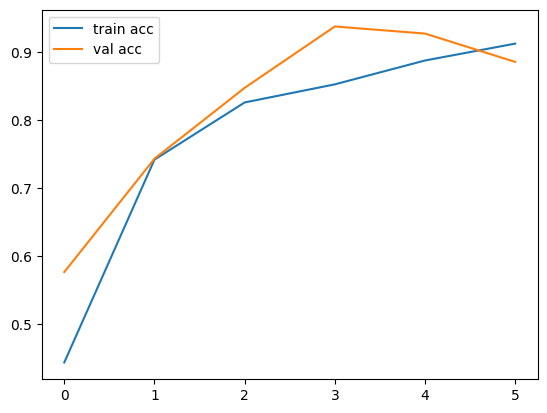

In [58]:
#accuracy
plt.plot(history.history['accuracy'], label= 'train acc')
plt.plot(history.history['val_accuracy'], label= 'val acc')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

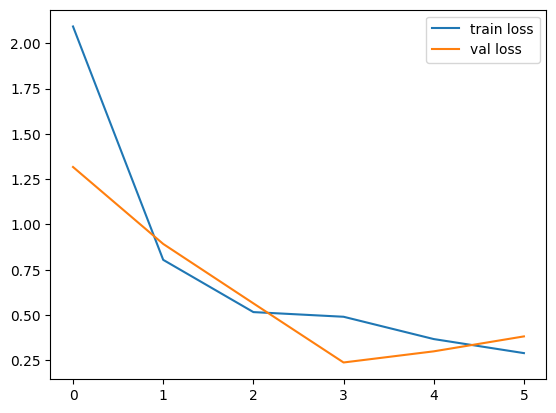

In [59]:
#loss
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'val loss')
plt.legend()
plt.show

## Inference

In [60]:
pip install opencv-python

1/1 [==============================] - 0s 46ms/step
[[4.19549440e-04 4.17452102e-04 5.10785355e-07 3.97053384e-07
  1.02010323e-04 2.35800471e-07 1.58571652e-06 3.22771825e-06
  1.02576334e-04 1.98066500e-05 7.59212571e-06 4.56151565e-06
  2.03468602e-07 2.73976525e-06 7.51740572e-06 8.42468495e-08
  1.97956979e-05 5.94596895e-06 1.19758568e-07 6.70489499e-07
  9.98669386e-01 5.02667945e-07 4.81776929e-08 6.16867101e-06
  6.56025668e-06 7.34719094e-07 1.90918996e-07 2.81836219e-05
  1.19019342e-06 1.70563930e-04]]


'Piper Betle (Betel)'

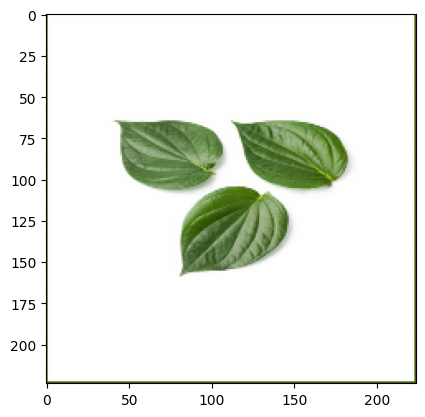

In [67]:
import cv2
out=['Alpinia Galanga (Rasna)',
 'Amaranthus Viridis (Arive-Dantu)',
 'Artocarpus Heterophyllus (Jackfruit)',
 'Azadirachta Indica (Neem)',
 'Basella Alba (Basale)',
 'Brassica Juncea (Indian Mustard)',
 'Carissa Carandas (Karanda)',
 'Citrus Limon (Lemon)',
 'Ficus Auriculata (Roxburgh fig)',
 'Ficus Religiosa (Peepal Tree)',
 'Hibiscus Rosa-sinensis',
 'Jasminum (Jasmine)',
 'Mangifera Indica (Mango)',
 'Mentha (Mint)',
 'Moringa Oleifera (Drumstick)',
 'Muntingia Calabura (Jamaica Cherry-Gasagase)',
 'Murraya Koenigii (Curry)',
 'Nerium Oleander (Oleander)',
 'Nyctanthes Arbor-tristis (Parijata)',
 'Ocimum Tenuiflorum (Tulsi)',
 'Piper Betle (Betel)',
 'Plectranthus Amboinicus (Mexican Mint)',
 'Pongamia Pinnata (Indian Beech)',
 'Psidium Guajava (Guava)',
 'Punica Granatum (Pomegranate)',
 'Santalum Album (Sandalwood)',
 'Syzygium Cumini (Jamun)',
 'Syzygium Jambos (Rose Apple)',
 'Tabernaemontana Divaricata (Crape Jasmine)',
 'Trigonella Foenum-graecum (Fenugreek)'
 ]
#Change the image path according to your comfort, try to use images which contains only single leaf
img=cv2.imread("/content/betelleage.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))
img=img/255.
import matplotlib.pyplot as plt
plt.imshow(img)
img=img.reshape(1,224,224,3)
import numpy as np
res=main_model.predict(img)
print(res)
out[np.argmax(res)]

In [62]:
#predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(val_generator)


9/9 [==============================] - 4s 372ms/step


In [63]:
test_y = val_generator.classes

In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [65]:
tflite_model = converter.convert()

In [ ]:
tflite_model

In [ ]:
with open('model.tflite', 'wb') as model_:
    model_.write(tflite_model)